# Extrair imagens dos arquivos dos escaners 

In [ ]:
#**Executar este comando apenas na primeira vez**
!pip install large-image==1.6.2

In [ ]:
#**Executar este comando apenas na primeira vez**
!pip install large-image[all] girder-large-image-annotation[tasks] --find-links https://girder.github.io/large_image_wheels

In [ ]:
#**Executar este comando apenas na primeira vez**
!pip install large-image[all] --find-links https://girder.github.io/large_image_wheels

## Execução ##

In [1]:
import large_image
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

    #Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['image.cmap'] = 'gray'

from PIL import Image

In [2]:
import threading

**substitua os valores das variaveis a seguir**

In [3]:
path = "/media/joel/New Volume/work/TireoideWork/arquivos-tireoide/arquivos-escaners/" #local do arquivo
to_path = "/media/joel/New Volume/work/TireoideWork/arquivos-tireoide/extract-tiles" #pasta vazia de onde deseja salvar as imagens. Sugerido colocar o mesmo nome do arquivo.

In [4]:
ts = large_image.getTileSource(path+"/DigitalSlide_D7M_6S_1.mrxs")

TileSourceException: No available tilesource for /media/joel/New Volume/work/TireoideWork/arquivos-tireoide/arquivos-escaners//DigitalSlide_D7M_6S_1.mrxs

In [13]:
ts.getMetadata()

{'levels': 12,
 'sizeX': 272128,
 'sizeY': 294144,
 'tileWidth': 256,
 'tileHeight': 256,
 'magnification': 20.0,
 'mm_x': 0.000242534722222222,
 'mm_y': 0.000242647058823529}

In [14]:
ts.getTileCount()

1221387

In [15]:
def not_content_RGB(p): #Tome RGB como três eixos coordenados.
  """
  Se a média dos valores RGB estão próximos de 1, então provavelmente são imagens
  em branco.
  Os pixels estão entre 0 e 1.
  """
  return (p[0]-1)**2+(p[1]-1)**2+(p[2]-1)**2 <= 0.2 or (p[0])**2+(p[1])**2+(p[2])**2 <= 0.2

In [16]:
def not_content_RGBA(p): #Tome RGB como três eixos coordenados.
  """
  Se a média dos valores RGB estão próximos de 1, então provavelmente são imagens
  em branco.
  Os pixels estão entre 0 e 1.
  """
  return (p[0]-1)**2+(p[1]-1)**2+(p[2]-1)**2 <= 0.2 or (p[0])**2+(p[1])**2+(p[2])**2 <= 0.2 or p[3] < 0.9

In [38]:
def extract(r, file, to_path, min_, X):
    X = list(X)
    ts = large_image.getTileSource(file)
    i = 0
    s = 0
    
    f = not_content_RGB
    for interator in ts.tileIterator(
        tile_size=dict(width=r, height=r)
        ):
      if i < min_:
        i = i+1
        continue
        
      im_tile = np.array(interator['tile'])
      im_tile = im_tile/255.
      tile_mean_rgb = np.mean(im_tile[:, :, :4], axis=(0, 1))
      
      if len(tile_mean_rgb) == 4 and i == 0:
        f = not_content_RGBA
        
      if not f(tile_mean_rgb):
        
        """
        uri = to_path+"/"+str(i)+".png"
        if os.path.isfile(uri):
            print("skiped")
            continue
        """
        im_tile = im_tile[:,:,:3]
        X.append(im_tile)
        s = s+1
        
        if s == 100:
            plt.imshow(im_tile)
            return X

      i = i+1
    print("Foram ", i, " tiles na imagem, ", s, " tiles salvos.")

**Função para extrair as imagens**

In [19]:
files = {
    "DigitalSlide_D7M_10S_1":"benigno",
    "DigitalSlide_D7M_5S_1": "maligno",
    "DigitalSlide_D7M_1S_1":"maligno",
    "DigitalSlide_D7M_6S_1":"benigno",
    "DigitalSlide_D7M_2S_1":"maligno",
    "DigitalSlide_D7M_7S_1":"benigno",
    "DigitalSlide_D7M_3S_1":"maligno",
    "DigitalSlide_D7M_8S_1":"benigno",
    "DigitalSlide_D7M_4S_1":"maligno",
    "DigitalSlide_D7M_9S_1":"benigno"
}
m = []
b = []

for key in files:
    
    if "maligno" in files[key]:
        m.append(key)
    else:
        b.append(key)

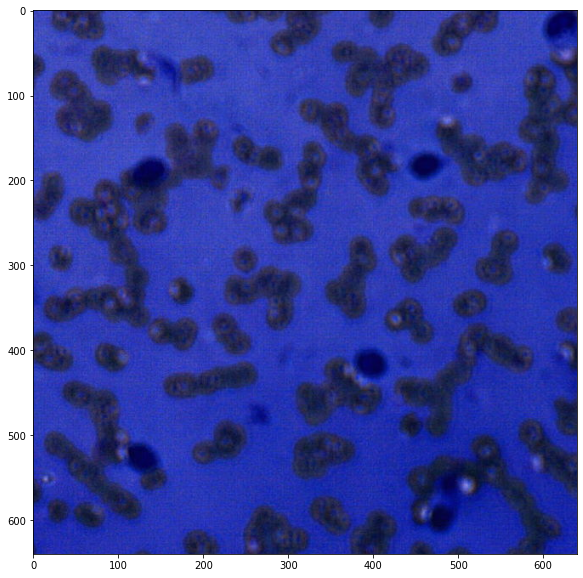

In [39]:
min_ = 24615
X = extract(640,
        path+"/DigitalSlide_D7M_7S_1.mrxs",
        to_path+"/benigno/DigitalSlide_D7M_7S_1",
       min_, list())

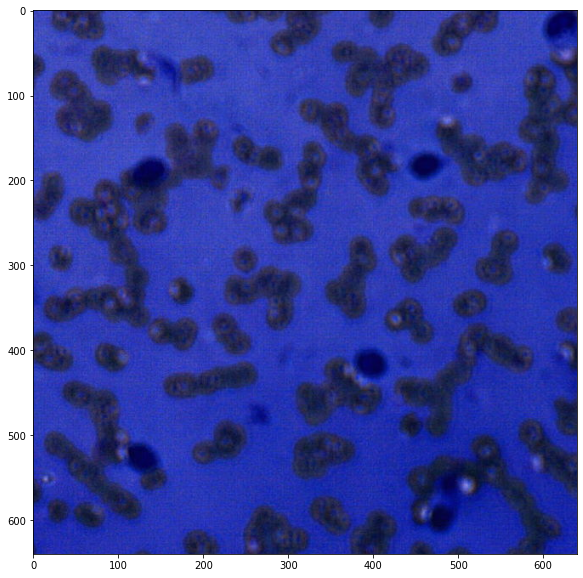

In [42]:
plt.imshow(X[99])

**As imagens são te 4 canais, RGBA. Nesse sentido, não pôde ser convertida para JPG diretamente, o código abaixo converte para jpg**

In [ ]:
#fonte: https://stackoverflow.com/questions/9166400/convert-rgba-png-to-rgb-with-pil
from PIL import Image
import glob



In [ ]:
#converter todas as imagens
def convert(list_f, path):
    #path é a pasta mãe que contém todas as imagens extraídas (link completo)
    def png_to_jpg(image_uri):
        png = Image.open(image_uri)
        png.load() # required for png.split()

        background = Image.new("RGB", png.size, (255, 255, 255))
        background.paste(png, mask=png.split()[3]) # 3 is the alpha channel

        base = os.path.split(image_uri)
        name = base[1].replace(".png",".jpg")

        background.save(base[0]+"/"+name, 'JPEG', quality=100)

        os.remove(image_uri)
    
    #list_f é a lista dos nomes dos arquivos de escaners.
    for sub in list_f:
        #path é a pasta criada com todos os arquivos
        image_path = path+"/"+sub
        print(image_path)
        for image in glob.glob(image_path+"/*.png"):
            png_to_jpg(image)

In [ ]:
x = threading.Thread(target=convert, args=(m, to_path+"/maligno"))
x.start()